# Training UNet for drop segmentation

In [1]:
import torch
from checkpoints import *
from measures import *

In [2]:
config = {
    "lr": 0.002,
    "batch_size": 8,
    "epochs": 10,
    "threshold": 0.35,
    "init_from_checkpoint": False,
    "input_mode": "RGBD",
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "checkpoints",
    "checkpoint": None, # if None loads last saved checkpoint
    "print_model": False,
    "binarization": True,
    "seed": 3407 # if None uses random seed
}
config["channels"] = len(config["input_mode"])
print(f"Training using {config['device']}")

Training using cuda


In [3]:
# Set seed
if config["seed"] is not None:
    torch.manual_seed(config["seed"])  

In [4]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    mode=config["input_mode"],
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    binarization = config["binarization"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 77 batches
Val: 67 images, 9 batches


In [5]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet, RUNet
from unet import init_weights
from pathlib import Path
from torch.optim import lr_scheduler

model = RUNet(config["channels"]).to(config['device'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=config["lr"])

# Load or fill weights
# And set the start_epoch of model
if config["init_from_checkpoint"]:
    # Load checkpoint
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    
    # Load model & optim from checkpoint
    model.load_state_dict(checkpoint["model_state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=5,
    gamma=0.7
)

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [6]:
def validate(model, loss_fn):
    import math
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    ious = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            
            
            if not math.isnan(loss.item()):
                losses.append(loss.item())
            else:
                print("Nan on validation")
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            if config["binarization"]:
                pred = (pred >= config["threshold"])
            
            accuracies.append(accuracy(y, pred))
            ious.append(IoU(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
    model.train()         
    mean = lambda l: sum(l) / len(l) if len(l) > 0 else -1
    return mean(losses), mean(ious), mean(accuracies), mean(precisions), mean(recalls)

In [7]:
a, y = next(iter(train_loader))

In [8]:
pred = torch.zeros_like(y)+1

In [9]:
def ch_score(checkpoint):
    return checkpoint["iou"]

In [10]:
best_checkpoint = {
    "name": "nullcheck",
    "epochs": 0,
    "model_state_dict": [],
    "optimizer_state_dict": [],
    "train_loss": 1e100,
    "val_loss": 1e100,
    "iou": 0,
    "accuracy": 0,
    "precision": 0,
    "recall": 0
}

In [11]:
from tqdm.notebook import tqdm
from sys import stdout
import math
def train(save_checkpoints=True, lr=None):
    # If lr=None, learning rate is used from optimizer
    if lr is not None:
        optimizer.param_groups[0]["lr"] = lr
    global best_checkpoint
    
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch, "| lr", optimizer.state_dict()["param_groups"][0]["lr"])
        
        loader = tqdm(train_loader)
        losses = []

        # Training this epoch
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                if math.isnan(torch.max(pred)):
                    print(f"NaN pred occured")
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            train_loss = loss.item()
            if math.isnan(train_loss):
                print(f"NaN loss occured")
                return
            
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)
            
        optimizer.step()
        scheduler.step()


        # Compute metrics
        train_loss = sum(losses) / len(losses)
        checkpoint = get_checkpoint( 
                model,
                config["input_mode"],
                optimizer,
                loss_fn,
                epoch,
                train_loss,
                *validate(model, loss_fn)
            )
        print_checkpoint(checkpoint)
        
        if save_checkpoints:
            save_checkpoint(
                checkpoint,
                config["checkpoint_dir"],
                checkpoint["name"]
            )
        # Find best checkpoint
        elif ch_score(best_checkpoint) < ch_score(checkpoint):
            best_checkpoint = checkpoint

In [12]:
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 0 | lr 0.002


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.806216215932524
Valid BCE loss: 0.620836098988851
IoU:       0.2723800721203765 

Accuracy:  0.6136512049922236
Precision: 0.29311231175368585
Recall:    0.3946242167588038 

Epoch 1 | lr 0.002


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.6046545466819366
Valid BCE loss: 0.5984762277868059
IoU:       0.4243951051903284 

Accuracy:  0.5920670827229818
Precision: 0.6070329032976318
Recall:    0.3945442794488485 

Epoch 2 | lr 0.002


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.5930641378675189
Valid BCE loss: 0.6098252766662173
IoU:       0.21081796315725737 

Accuracy:  0.6886930112485533
Precision: 0.1574257915598099
Recall:    0.4860881530067895 

Epoch 3 | lr 0.002


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.5742311106099711
Valid BCE loss: 0.5549861457612779
IoU:       0.49252391718990496 

Accuracy:  0.6281102498372396
Precision: 0.7618088001316344
Recall:    0.42314345953919125 

Epoch 4 | lr 0.002


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.5383588149176015
Valid BCE loss: 0.5504500899049971
IoU:       0.5056552530653871 

Accuracy:  0.6214938693576388
Precision: 0.8177311866095773
Recall:    0.41459247037166197 

Epoch 5 | lr 0.0014


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.5217550234361128
Valid BCE loss: 0.5979316929976145
IoU:       0.49201788645131017 

Accuracy:  0.6109246854428892
Precision: 0.8112030904050226
Recall:    0.4068048660162032 

Epoch 6 | lr 0.0014


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.5078754185082076
Valid BCE loss: 0.5915575358602736
IoU:       0.4853251618810548 

Accuracy:  0.5838666845251013
Precision: 0.8325670778199479
Recall:    0.40695465464421005 

Epoch 7 | lr 0.0014


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4969294195051317
Valid BCE loss: 0.48279306954807705
IoU:       0.5030283457396166 

Accuracy:  0.7821616420039423
Precision: 0.49214790511393436
Recall:    0.6146213656030342 

Epoch 8 | lr 0.0014


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4868447796090857
Valid BCE loss: 0.5150381724039713
IoU:       0.5252208808486638 

Accuracy:  0.6694742838541666
Precision: 0.7943499068281166
Recall:    0.4498537217035975 

Epoch 9 | lr 0.0014


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.48493413762612775
Valid BCE loss: 0.4690771930747562
IoU:       0.5333007085968896 

Accuracy:  0.7901209372061271
Precision: 0.5370352452025853
Recall:    0.63580567586705 



In [13]:
print_checkpoint(best_checkpoint)

Train BCE loss: 0.48493413762612775
Valid BCE loss: 0.4690771930747562
IoU:       0.5333007085968896 

Accuracy:  0.7901209372061271
Precision: 0.5370352452025853
Recall:    0.63580567586705 



In [14]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

Progress saved to 'checkpoints/RUNetRGBDBCEt48v46e9.pt'


In [15]:
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 10 | lr 0.00098


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4657661013014905
Valid BCE loss: 0.5470149285263486
IoU:       0.5471721569567056 

Accuracy:  0.6394929532651549
Precision: 0.8783977418724034
Recall:    0.4354879322392394 

Epoch 11 | lr 0.00098


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.45448948423583785
Valid BCE loss: 0.43353333075841266
IoU:       0.5932828570746274 

Accuracy:  0.7525976675528068
Precision: 0.8188987617139464
Recall:    0.5040622479545135 

Epoch 12 | lr 0.00098


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4599417049389381
Valid BCE loss: 0.4385947287082672
IoU:       0.5424489790820792 

Accuracy:  0.805656009250217
Precision: 0.5396439721807837
Recall:    0.6591836308482075 

Epoch 13 | lr 0.00098


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4509194725519651
Valid BCE loss: 0.4223611255486806
IoU:       0.5834889316116744 

Accuracy:  0.7571165296766493
Precision: 0.7978817172072552
Recall:    0.5006124093877397 

Epoch 14 | lr 0.00098


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4373667189827213
Valid BCE loss: 0.4251628683673011
IoU:       0.6090474001957807 

Accuracy:  0.7915758910002532
Precision: 0.6876249066726478
Recall:    0.5887675359440023 

Epoch 15 | lr 0.000686


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4415086933544704
Valid BCE loss: 0.4817146890693241
IoU:       0.5780755119146747 

Accuracy:  0.6887631592927156
Precision: 0.8846928840158162
Recall:    0.46587168370247795 

Epoch 16 | lr 0.000686


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.43185311633271056
Valid BCE loss: 0.4196169210804833
IoU:       0.5967083305403313 

Accuracy:  0.7667323218451606
Precision: 0.7756228499390461
Recall:    0.5298774093778751 

Epoch 17 | lr 0.000686


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4392873172636156
Valid BCE loss: 0.4441991382175022
IoU:       0.5836062025098446 

Accuracy:  0.7290543450249566
Precision: 0.8124912878567422
Recall:    0.5167287196186944 

Epoch 18 | lr 0.000686


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4276580489301062
Valid BCE loss: 0.43575675951109993
IoU:       0.5939890454015162 

Accuracy:  0.7504307075783059
Precision: 0.8052458024963185
Recall:    0.5059158058044334 

Epoch 19 | lr 0.000686


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.42630302325471653
Valid BCE loss: 0.4301534626219008
IoU:       0.5904528375943885 

Accuracy:  0.7500367341218172
Precision: 0.8004284814276077
Recall:    0.515704635188755 



In [16]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

Progress saved to 'checkpoints/RUNetRGBDBCEt43v42e14.pt'


In [17]:
model.load_state_dict(best_checkpoint["model_state_dict"])
#config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 20 | lr 0.00048019999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4123870622028004
Valid BCE loss: 0.40773439076211715
IoU:       0.622754190842573 

Accuracy:  0.7716190196849682
Precision: 0.8088193953865104
Recall:    0.5415341411690899 

Epoch 21 | lr 0.00048019999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.41988284440783713
Valid BCE loss: 0.4005130496289995
IoU:       0.6127949324916345 

Accuracy:  0.7739309381555628
Precision: 0.8082391919085272
Recall:    0.5229998102229314 

Epoch 22 | lr 0.00048019999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4219249328235527
Valid BCE loss: 0.40992850065231323
IoU:       0.6296124627075188 

Accuracy:  0.7828809243661385
Precision: 0.7654464154469747
Recall:    0.5683175682056938 

Epoch 23 | lr 0.00048019999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4196461640395127
Valid BCE loss: 0.4018116825156742
IoU:       0.6167007170827027 

Accuracy:  0.7800023820665147
Precision: 0.8032733813204147
Recall:    0.5259553938415321 

Epoch 24 | lr 0.00048019999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4181396299368375
Valid BCE loss: 0.44117676549487644
IoU:       0.5985676597081191 

Accuracy:  0.7322480943467882
Precision: 0.8343408125004284
Recall:    0.5032695730491775 

Epoch 25 | lr 0.00033613999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4226970061079248
Valid BCE loss: 0.4024253222677443
IoU:       0.6116064227592424 

Accuracy:  0.7690784313060619
Precision: 0.8208778431570088
Recall:    0.5276412946630156 

Epoch 26 | lr 0.00033613999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4009163077775534
Valid BCE loss: 0.4008336100313399
IoU:       0.6488282647258163 

Accuracy:  0.7841125770851418
Precision: 0.8164550234322195
Recall:    0.5667885595348807 

Epoch 27 | lr 0.00033613999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.40318250694832247
Valid BCE loss: 0.40410223603248596
IoU:       0.6413455966259396 

Accuracy:  0.7797374018916376
Precision: 0.8067507826619678
Recall:    0.5641014973162422 

Epoch 28 | lr 0.00033613999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4119141721106195
Valid BCE loss: 0.3725039561589559
IoU:       0.6451681406913372 

Accuracy:  0.8212381292272497
Precision: 0.7248216161021479
Recall:    0.6300638051803857 

Epoch 29 | lr 0.00033613999999999996


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4043711323242683
Valid BCE loss: 0.3970739013618893
IoU:       0.6320234947694886 

Accuracy:  0.7685455746120877
Precision: 0.8458790990903422
Recall:    0.5319337755654762 



In [18]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

Progress saved to 'checkpoints/RUNetRGBDBCEt40v40e26.pt'


In [19]:
model.load_state_dict(best_checkpoint["model_state_dict"])
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 30 | lr 0.00023529799999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.4025685024725926
Valid BCE loss: 0.3810488780339559
IoU:       0.6618782908846973 

Accuracy:  0.8017625455503111
Precision: 0.7853653954548968
Recall:    0.6026596191669495 

Epoch 31 | lr 0.00023529799999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.3981038738380779
Valid BCE loss: 0.4102315406004588
IoU:       0.6403458898665907 

Accuracy:  0.7765250029387297
Precision: 0.7900719184566427
Recall:    0.5839918302709284 

Epoch 32 | lr 0.00023529799999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39196494337800264
Valid BCE loss: 0.3923245668411255
IoU:       0.659076722514119 

Accuracy:  0.7948103304262514
Precision: 0.7880513978501161
Recall:    0.5989013019514746 

Epoch 33 | lr 0.00023529799999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.40477042383961864
Valid BCE loss: 0.3635333743360307
IoU:       0.6592151718997298 

Accuracy:  0.8257388362178095
Precision: 0.7507820079723994
Recall:    0.6287844384380104 

Epoch 34 | lr 0.00023529799999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39280313756558805
Valid BCE loss: 0.38716191715664333
IoU:       0.659984238745838 

Accuracy:  0.7925418571189597
Precision: 0.8064988753585903
Recall:    0.5901271706605475 

Epoch 35 | lr 0.00016470859999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39427564631808887
Valid BCE loss: 0.376769138707055
IoU:       0.6305944065033446 

Accuracy:  0.8173443829571759
Precision: 0.7100836379384553
Recall:    0.6171773330783186 

Epoch 36 | lr 0.00016470859999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.3961818957483614
Valid BCE loss: 0.37877149714363945
IoU:       0.6625237406805686 

Accuracy:  0.7968581870750144
Precision: 0.85168547583399
Recall:    0.5693670855887786 

Epoch 37 | lr 0.00016470859999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39734338359399274
Valid BCE loss: 0.38623273372650146
IoU:       0.6461587749845747 

Accuracy:  0.7850523348207826
Precision: 0.8162257159473719
Recall:    0.565472850601948 

Epoch 38 | lr 0.00016470859999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39257287321152623
Valid BCE loss: 0.38269317481252885
IoU:       0.6470480629452371 

Accuracy:  0.7954090259693287
Precision: 0.7958034991666123
Recall:    0.5869599895860806 

Epoch 39 | lr 0.00016470859999999997


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39427680976979146
Valid BCE loss: 0.3992826888958613
IoU:       0.6099904379904459 

Accuracy:  0.7581279895923756
Precision: 0.8673607793947061
Recall:    0.49913895353259513 



In [20]:
print_checkpoint(best_checkpoint)

Train BCE loss: 0.3961818957483614
Valid BCE loss: 0.37877149714363945
IoU:       0.6625237406805686 

Accuracy:  0.7968581870750144
Precision: 0.85168547583399
Recall:    0.5693670855887786 



In [21]:
model.load_state_dict(best_checkpoint["model_state_dict"])

<All keys matched successfully>

In [22]:
model.load_state_dict(best_checkpoint["model_state_dict"])
start_epoch = best_checkpoint["epochs"]
config["epochs"] = 10
train(save_checkpoints=False)
start_epoch = start_epoch + config["epochs"]

Epoch 37 | lr 0.00011529601999999998


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.3981413690300731
Valid BCE loss: 0.3940186599890391
IoU:       0.6664430180467654 

Accuracy:  0.8029944101969401
Precision: 0.7823898213467113
Recall:    0.6198476958192014 

Epoch 38 | lr 0.00011529601999999998


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39236511193312607
Valid BCE loss: 0.3635173837343852
IoU:       0.658238802059863 

Accuracy:  0.8178780873616537
Precision: 0.7584948556980602
Recall:    0.6270163783167163 

Epoch 39 | lr 0.00011529601999999998


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.389790298102738
Valid BCE loss: 0.3867371678352356
IoU:       0.6377704708920084 

Accuracy:  0.7975519674795646
Precision: 0.7552481307475655
Recall:    0.596595404578746 

Epoch 40 | lr 0.00011529601999999998


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.38642493819261525
Valid BCE loss: 0.3969240089257558
IoU:       0.6257044272702125 

Accuracy:  0.7739231674759476
Precision: 0.8267673180886992
Recall:    0.5351006695337123 

Epoch 41 | lr 0.00011529601999999998


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.38931314047280846
Valid BCE loss: 0.35962910453478497
IoU:       0.6514813057744328 

Accuracy:  0.8106153276231554
Precision: 0.7885347243260454
Recall:    0.5867761899466546 

Epoch 42 | lr 8.070721399999998e-05


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.39860383992071274
Valid BCE loss: 0.37889178262816536
IoU:       0.6493861201384781 

Accuracy:  0.8054800386782045
Precision: 0.7801495824974995
Recall:    0.5942399322096001 

Epoch 43 | lr 8.070721399999998e-05


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.3953680434784332
Valid BCE loss: 0.389620261059867
IoU:       0.6494680519787611 

Accuracy:  0.7842894660101997
Precision: 0.8169872976701569
Recall:    0.5708803217938924 

Epoch 44 | lr 8.070721399999998e-05


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.3824882097058482
Valid BCE loss: 0.3664981921513875
IoU:       0.6577679435158454 

Accuracy:  0.82074949476454
Precision: 0.746320110987182
Recall:    0.6313237745747594 

Epoch 45 | lr 8.070721399999998e-05


  0%|          | 0/77 [00:00<?, ?it/s]

Train BCE loss: 0.3862497593675341
Valid BCE loss: 0.3993687662813399
IoU:       0.6383856573730324 

Accuracy:  0.7789484659830729
Precision: 0.8052292490309035
Recall:    0.5649602575464395 

Epoch 46 | lr 8.070721399999998e-05


  0%|          | 0/77 [00:00<?, ?it/s]

Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Nan on validation
Train BCE loss: 0.3892690221984665
Valid BCE loss: -1
IoU:       0.0 

Accuracy:  0.6811309390597873
Precision: 0.0
Recall:    0.0 



In [23]:
save_checkpoint(
                best_checkpoint,
                config["checkpoint_dir"],
                best_checkpoint["name"]
            )

Progress saved to 'checkpoints/RUNetRGBDBCEt39v39e37.pt'


# Estimation

In [24]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [25]:
def show_channels(x):
    x = x.detach().numpy()
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np

    fig, axs = plt.subplots(1, config["channels"])
    for ax, c in zip(axs, x):
        ax.imshow(c, cmap='gray')
    plt.show()

In [26]:
def plot_prediction(x, y, binary_map=True, binary_threshold=0.42):
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("IoU:      ", IoU([y], [pred]))
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    img = np.transpose(x[:3], (1, 2, 0))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 42


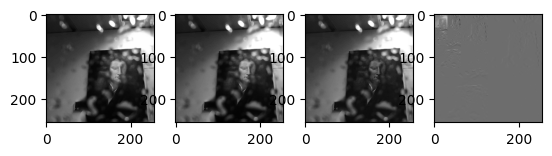

IoU:       0.0
Accuracy:  0.723785400390625
Precision: 0.0
Recall:    0.0


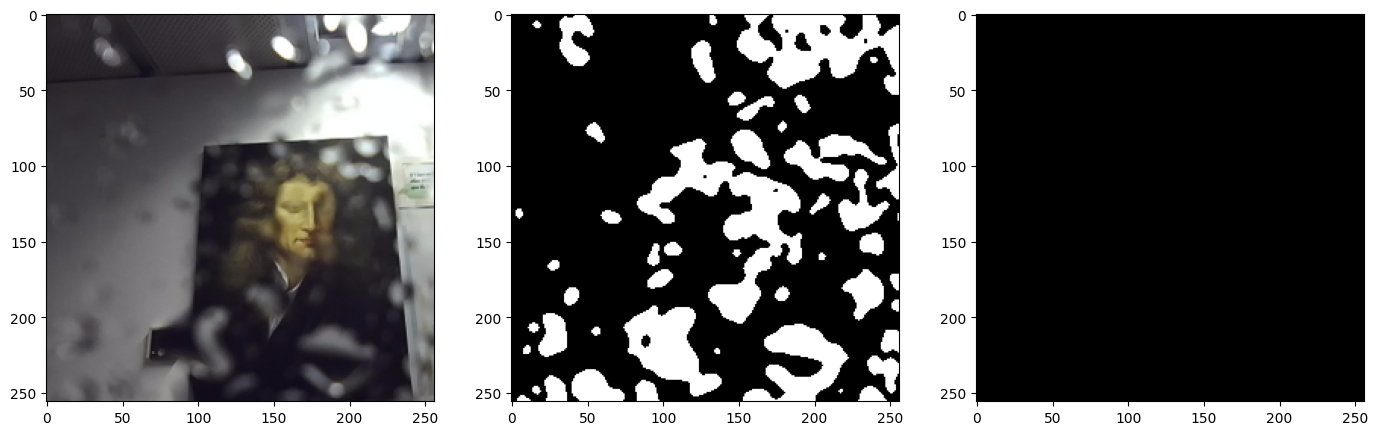

In [27]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
x, y = val_dataset[idx]
show_channels(x)
plot_prediction(x, y, binary_map=True, binary_threshold=config["threshold"])

IoU:       nan
Accuracy:  nan
Precision: nan
Recall:    nan


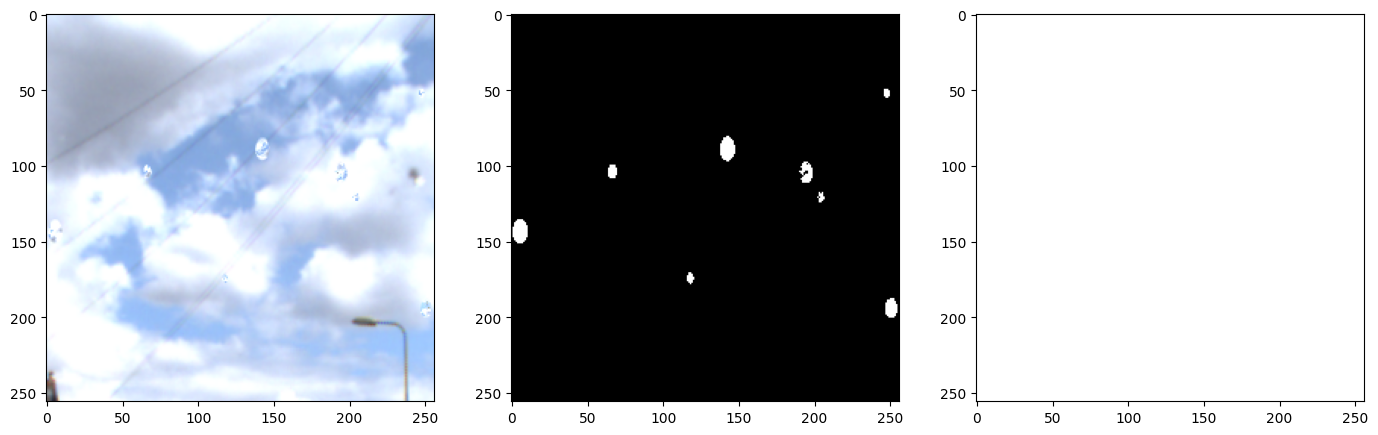

In [28]:
# Get prediction from opened image
image_path = "../../data/derain/ALIGNED_PAIRS/CG_DROPLETS/left_1535201264389466.png"
mask_path = "../../data/derain/ALIGNED_PAIRS/CG_MASKS/left_1535201264389466.png"
from PIL import Image, ImageFilter
image = Image.open(image_path)
mask  = Image.open(mask_path)
x, y = dataset.transform(image, mask)
plot_prediction(x, y, binary_map=False)

In [29]:
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["train_loss"] >= 0.37, save_last=1)

In [30]:
!ls -la checkpoints

total 30128648
drwxrwsr-x 2 kondrashov students     12288 Aug 15 01:41 .
drwxrwsr-x 8 kondrashov students      4096 Aug 15 01:39 ..
-rw-rw-r-- 1 kondrashov students       627 Aug 12 16:00 nullcheck
-rw-rw-r-- 1 kondrashov students 430049085 Aug 15 01:41 RUNetRGBDBCEt39v39e37.pt
-rw-rw-r-- 1 kondrashov students 430049085 Aug 15 01:07 RUNetRGBDBCEt40v40e26.pt
-rw-rw-r-- 1 kondrashov students 430049085 Aug 15 00:45 RUNetRGBDBCEt43v42e14.pt
-rw-rw-r-- 1 kondrashov students 430048675 Aug 15 00:16 RUNetRGBDBCEt48v46e9.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  9 14:51 UNetAdamBCEt25v31e69.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  9 14:51 UNetAdamBCEt26v29e66.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  9 14:51 UNetAdamBCEt26v30e62.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  9 14:51 UNetAdamBCEt26v30e67.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  9 14:51 UNetAdamBCEt27v30e68.pt
-rw-rw-r-- 1 kondrashov students 372617581 Aug 11 18:12 UNetAdamBCEt36v33e66.pt

In [31]:
!ls final_models

UNetAdamBCEt25v31e69.pt  UNetRGBBCEt31v32e53.pt
UNetAdamBCEt26v29e66.pt  UNetRGBSBCEt31v31e56.pt


In [32]:
!cp checkpoints/UNetRGBSBCEt31v31e56.pt final_models

In [33]:
def modify_dataset():
    # Modify images to make them smoother
    save_dir = '../../data/derain/ALIGNED_PAIRS/CG_DROPLETS_M7'
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    step = 1
    for path in Path(config["image_dir"]).glob('*.png'):
        image = Image.open(path)
        image = image.filter(ImageFilter.MedianFilter(size = 5))
        new_path = Path(save_dir, path.name)
        image.save(new_path)
        print("Saved", new_path, step)
        step = step + 1